In [5]:
!pip install opencv-python
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd
import os
import cv2


In [6]:
def rgb_to_hsv(img):

    # chuyển về khoảng 0-255
    img_255 = (img * 255).astype(np.uint8)
    
    # rgb->hsv
    img_hsv = cv2.cvtColor(img_255, cv2.COLOR_RGB2HSV)
    

    img_hsv = img_hsv.astype(np.float32)
    img_hsv[:, :, 0] = img_hsv[:, :, 0] / 179.0  # H
    img_hsv[:, :, 1] = img_hsv[:, :, 1] / 255.0  # S
    img_hsv[:, :, 2] = img_hsv[:, :, 2] / 255.0  # V
    
    return img_hsv
class ImageDataGeneratorHSV(ImageDataGenerator):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def standardize(self, x):
        x = super().standardize(x)  # rescale
        x = rgb_to_hsv(x)  # -->hsv
        return x

In [7]:
# Đường dẫn dataset
train_dir = "../dataset_splits/train"
validation_dir = "../dataset_splits/validation"
test_dir = "../dataset_splits/test"

# Hyperparameters
image_size = 150
batch_size = 32
epochs = 15       #đổi số epoch để chạy nhiều hơn dùm nha
learning_rate = 1e-3
num_classes = 6
color_mode="hsv"
channels = 3  

In [8]:

train_datagen = ImageDataGeneratorHSV(rescale=1./255)
validation_datagen = ImageDataGeneratorHSV(rescale=1./255)
test_datagen = ImageDataGeneratorHSV(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Lưu class names
class_names = list(train_generator.class_indices.keys())

steps_per_epoch = int(np.ceil(train_generator.samples / batch_size))
validation_steps = int(np.ceil(validation_generator.samples / batch_size))
test_steps = int(np.ceil(test_generator.samples / batch_size))

print(f"Classes: {list(train_generator.class_indices.keys())}")
print(f"  Mẫu Training:   {train_generator.samples:>5} → {steps_per_epoch:>3} steps")
print(f"  Mẫu Validation: {validation_generator.samples:>5} → {validation_steps:>3} steps")
print(f"  Mẫu Test:       {test_generator.samples:>5} → {test_steps:>3} steps")
print(f"  Input shape:    ({image_size}, {image_size}, {channels}) - HSV")

Found 7245 images belonging to 6 classes.
Found 1355 images belonging to 6 classes.
Found 448 images belonging to 6 classes.
Classes: ['0', '1', '2', '3', '4', '5']
  Mẫu Training:    7245 → 227 steps
  Mẫu Validation:  1355 →  43 steps
  Mẫu Test:         448 →  14 steps
  Input shape:    (150, 150, 3) - HSV


In [9]:
#Xây dựng model
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', 
                 input_shape=(image_size, image_size, 3), name='conv1'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', name='conv2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', name='conv3'),
    layers.MaxPooling2D((2, 2), name='pool3'),
    
    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu', name='conv4'),
    layers.MaxPooling2D((2, 2), name='pool4'),
    
    # Fully Connected Layers
    layers.Flatten(name='flatten'),
    layers.Dropout(0.6, name='dropout'),
    layers.Dense(256, activation='relu', 
                kernel_regularizer=regularizers.l2(0.002), name='fc1'),
    layers.Dense(num_classes, activation='softmax', name='output')
])

# Hiển thị kiến trúc model
model.summary()

c:\Users\ADMIN\Documents\Tomato-Leaf-Diseases-Image-Classification-Using-Deep-Learning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,601,478 (13.74 MB)

 Trainable params: 3,601,478 (13.74 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

In [11]:
callbacks = [
    ModelCheckpoint(
        './saved_model/tomato_hsv_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

# Lưu model cuối cùng
model.save('./saved_model/tomato_hsv_final.h5')

Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.5120 - auc: 0.8223 - loss: 1.5945 - precision: 0.7031 - recall: 0.3252
Epoch 1: val_accuracy improved from None to 0.78967, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 1: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 115s 498ms/step - accuracy: 0.6502 - auc: 0.9129 - loss: 1.1515 - precision: 0.7858 - recall: 0.5266 - val_accuracy: 0.7897 - val_auc: 0.9657 - val_loss: 0.7557 - val_precision: 0.8333 - val_recall: 0.7269 - learning_rate: 0.0010
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7912 - auc: 0.9681 - loss: 0.7354 - precision: 0.8443 - recall: 0.7464
Epoch 2: val_accuracy improved from 0.78967 to 0.87454, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 2: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - accuracy: 0.8150 - auc: 0.9740 - loss: 0.6873 - precision: 0.8598 - recall: 0.7760 - val_accuracy: 0.8745 - val_auc: 0.9879 - val_loss: 0.5426 - val_precision: 0.8951 - val_recall: 0.8443 - learning_rate: 0.0010
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.8673 - auc: 0.9847 - loss: 0.5753 - precision: 0.8902 - recall: 0.8391
Epoch 3: val_accuracy did not improve from 0.87454
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.8672 - auc: 0.9848 - loss: 0.5763 - precision: 0.8877 - recall: 0.8404 - val_accuracy: 0.8399 - val_auc: 0.9795 - val_loss: 0.6440 - val_precision: 0.8579 - val_recall: 0.8288 - learning_rate: 0.0010
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8931 - auc: 0.9902 - loss: 0.5062 - precision: 0.9091 - recall: 0.8722
Epoch 4: val_accuracy improved from 0.87454 to 0.90185, saving model to ./saved_model/t


Epoch 4: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.8941 - auc: 0.9901 - loss: 0.5038 - precision: 0.9100 - recall: 0.8761 - val_accuracy: 0.9018 - val_auc: 0.9902 - val_loss: 0.4919 - val_precision: 0.9155 - val_recall: 0.8878 - learning_rate: 0.0010
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9051 - auc: 0.9920 - loss: 0.4631 - precision: 0.9210 - recall: 0.8912
Epoch 5: val_accuracy improved from 0.90185 to 0.90258, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 5: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 254ms/step - accuracy: 0.9097 - auc: 0.9926 - loss: 0.4544 - precision: 0.9223 - recall: 0.8959 - val_accuracy: 0.9026 - val_auc: 0.9938 - val_loss: 0.4531 - val_precision: 0.9175 - val_recall: 0.8863 - learning_rate: 0.0010
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9310 - auc: 0.9949 - loss: 0.4011 - precision: 0.9395 - recall: 0.9244
Epoch 6: val_accuracy improved from 0.90258 to 0.91808, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 6: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 261ms/step - accuracy: 0.9286 - auc: 0.9949 - loss: 0.4030 - precision: 0.9374 - recall: 0.9219 - val_accuracy: 0.9181 - val_auc: 0.9943 - val_loss: 0.4377 - val_precision: 0.9277 - val_recall: 0.9085 - learning_rate: 0.0010
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.9221 - auc: 0.9946 - loss: 0.4198 - precision: 0.9313 - recall: 0.9151
Epoch 7: val_accuracy improved from 0.91808 to 0.94022, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 7: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 260ms/step - accuracy: 0.9248 - auc: 0.9949 - loss: 0.4176 - precision: 0.9334 - recall: 0.9162 - val_accuracy: 0.9402 - val_auc: 0.9960 - val_loss: 0.3961 - val_precision: 0.9483 - val_recall: 0.9343 - learning_rate: 0.0010
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9505 - auc: 0.9975 - loss: 0.3472 - precision: 0.9550 - recall: 0.9430
Epoch 8: val_accuracy did not improve from 0.94022
227/227 ━━━━━━━━━━━━━━━━━━━━ 66s 289ms/step - accuracy: 0.9455 - auc: 0.9967 - loss: 0.3590 - precision: 0.9496 - recall: 0.9391 - val_accuracy: 0.9299 - val_auc: 0.9956 - val_loss: 0.4010 - val_precision: 0.9441 - val_recall: 0.9225 - learning_rate: 0.0010
Epoch 9/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9502 - auc: 0.9975 - loss: 0.3411 - precision: 0.9538 - recall: 0.9462
Epoch 9: val_accuracy improved from 0.94022 to 0.94391, saving model to ./saved_model/t


Epoch 9: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 286ms/step - accuracy: 0.9434 - auc: 0.9971 - loss: 0.3516 - precision: 0.9474 - recall: 0.9401 - val_accuracy: 0.9439 - val_auc: 0.9969 - val_loss: 0.3600 - val_precision: 0.9542 - val_recall: 0.9380 - learning_rate: 0.0010
Epoch 10/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9548 - auc: 0.9979 - loss: 0.3223 - precision: 0.9576 - recall: 0.9512
Epoch 10: val_accuracy improved from 0.94391 to 0.96015, saving model to ./saved_model/tomato_hsv_best.h5



Epoch 10: finished saving model to ./saved_model/tomato_hsv_best.h5
227/227 ━━━━━━━━━━━━━━━━━━━━ 62s 275ms/step - accuracy: 0.9503 - auc: 0.9972 - loss: 0.3332 - precision: 0.9550 - recall: 0.9462 - val_accuracy: 0.9601 - val_auc: 0.9983 - val_loss: 0.3042 - val_precision: 0.9620 - val_recall: 0.9528 - learning_rate: 0.0010
Epoch 11/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9569 - auc: 0.9980 - loss: 0.3096 - precision: 0.9623 - recall: 0.9524
Epoch 11: val_accuracy did not improve from 0.96015
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - accuracy: 0.9569 - auc: 0.9981 - loss: 0.3086 - precision: 0.9620 - recall: 0.9528 - val_accuracy: 0.9550 - val_auc: 0.9977 - val_loss: 0.3102 - val_precision: 0.9561 - val_recall: 0.9483 - learning_rate: 0.0010
Epoch 12/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9592 - auc: 0.9985 - loss: 0.2939 - precision: 0.9626 - recall: 0.9574
Epoch 12: val_accuracy did not improve from 0.96015
227/227 ━━━━━━━━━━━━━━━━━━━━ 62

In [13]:
print("Đánh giá trên tập testing")
print("=" * 70)

# Evaluate model với số steps chính xác
test_results = model.evaluate(
    test_generator,
    steps=test_steps,
    verbose=1
)

# Lấy predictions trên toàn bộ tập test
test_generator.reset()
y_pred_probs = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# LẤY ĐÚNG SỐ LƯỢNG TRUE LABELS
y_true = test_generator.classes[:test_generator.samples]

# KIỂM TRA
print(f" Tổng mẫu test:    {test_generator.samples}")
print(f" Dự đoán được tạo: {len(y_pred)}")
print(f" Nhãn đúng được thu thập: {len(y_true)}")

# Đảm bảo cắt đúng số lượng
y_pred = y_pred[:test_generator.samples]
y_true = y_true[:test_generator.samples]

# Tính các metrics
test_precision = precision_score(y_true, y_pred, average='weighted')
test_recall = recall_score(y_true, y_pred, average='weighted')
test_f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "=" * 70)
print("Metric trên tập test")
print("=" * 70)
print(f"Test Loss:      {test_results[0]:.4f}")
print(f"Test Accuracy:  {test_results[1]*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
print(f"Test Recall:    {test_recall*100:.2f}%")
print(f"Test F1-Score:  {test_f1*100:.2f}%")
print(f"Test AUC:       {test_results[4]:.4f}")

Đánh giá trên tập testing
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step - accuracy: 0.9598 - auc: 0.9990 - loss: 0.2956 - precision: 0.9727 - recall: 0.9531
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
 Tổng mẫu test:    448
 Dự đoán được tạo: 448
 Nhãn đúng được thu thập: 448

Metric trên tập test
Test Loss:      0.2956
Test Accuracy:  95.98%
Test Precision: 95.98%
Test Recall:    95.98%
Test F1-Score:  95.98%
Test AUC:       0.9990


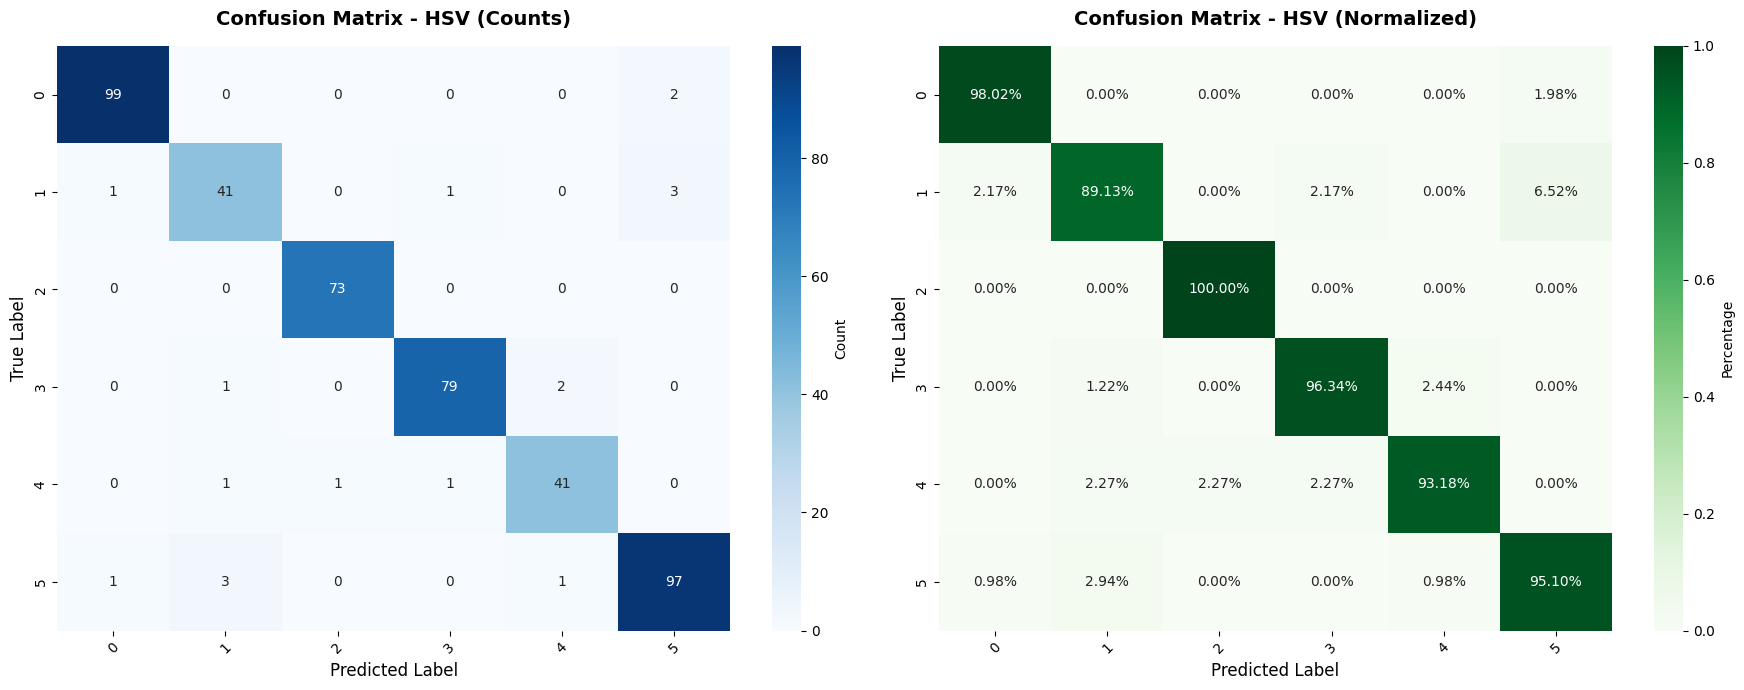


Classification Report (HSV)
              precision    recall  f1-score   support

           0     0.9802    0.9802    0.9802       101
           1     0.8913    0.8913    0.8913        46
           2     0.9865    1.0000    0.9932        73
           3     0.9753    0.9634    0.9693        82
           4     0.9318    0.9318    0.9318        44
           5     0.9510    0.9510    0.9510       102

    accuracy                         0.9598       448
   macro avg     0.9527    0.9530    0.9528       448
weighted avg     0.9598    0.9598    0.9598       448


Bảng metrics theo từng lớp:
              precision    recall  f1-score     support
0              0.980198  0.980198  0.980198  101.000000
1              0.891304  0.891304  0.891304   46.000000
2              0.986486  1.000000  0.993197   73.000000
3              0.975309  0.963415  0.969325   82.000000
4              0.931818  0.931818  0.931818   44.000000
5              0.950980  0.950980  0.950980  102.000000
accurac

In [14]:

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Confusion Matrix (Count)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Count'},
                ax=ax1)
    ax1.set_title('Confusion Matrix - HSV (Counts)', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    
    # Confusion Matrix (Normalized)
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cbar_kws={'label': 'Percentage'},
                ax=ax2)
    ax2.set_title('Confusion Matrix - HSV (Normalized)', fontsize=14, fontweight='bold', pad=15)
    ax2.set_ylabel('True Label', fontsize=12)
    ax2.set_xlabel('Predicted Label', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return cm

cm = plot_confusion_matrix(y_true, y_pred, class_names)

print("\nClassification Report (HSV)")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print("\nBảng metrics theo từng lớp:")
print(df_report.to_string())

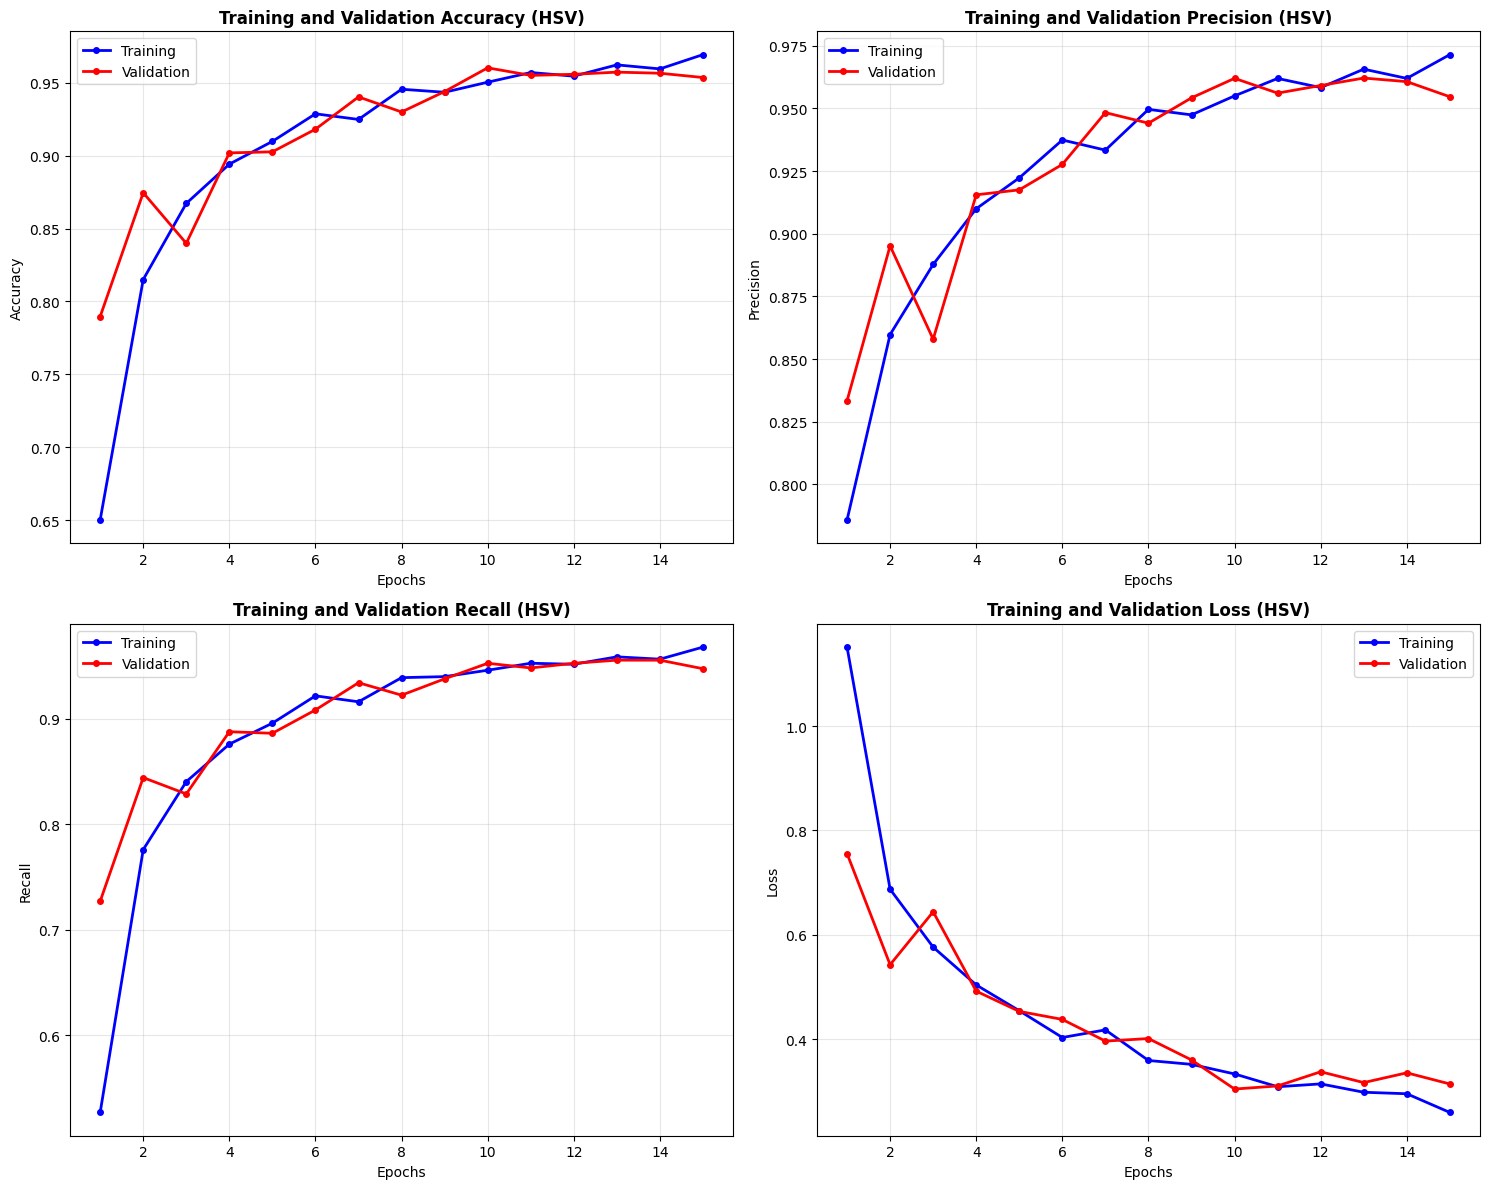


Kết quả training chi tiết (HSV)
Best Training Accuracy:    96.92%
Best Validation Accuracy:  96.01%
Best Training Precision:   97.15%
Best Validation Precision: 96.21%
Best Training Recall:      96.81%
Best Validation Recall:    95.57%
Final Training Loss:       0.2593
Final Validation Loss:     0.3140


In [15]:
def plot_training_history(history):
    """Vẽ biểu đồ quá trình training"""
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'loss']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        if metric == 'loss':
            train_metric = history.history['loss']
            val_metric = history.history['val_loss']
            title = 'Training and Validation Loss (HSV)'
            ylabel = 'Loss'
        else:
            train_metric = history.history[metric]
            val_metric = history.history[f'val_{metric}']
            title = f'Training and Validation {metric.capitalize()} (HSV)'
            ylabel = metric.capitalize()
        
        ax.plot(epochs_range, train_metric, 'bo-', label=f'Training', linewidth=2, markersize=4)
        ax.plot(epochs_range, val_metric, 'ro-', label=f'Validation', linewidth=2, markersize=4)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Epochs', fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("Kết quả training chi tiết (HSV)")
    print("=" * 70)
    print(f"Best Training Accuracy:    {max(history.history['accuracy'])*100:.2f}%")
    print(f"Best Validation Accuracy:  {max(history.history['val_accuracy'])*100:.2f}%")
    print(f"Best Training Precision:   {max(history.history['precision'])*100:.2f}%")
    print(f"Best Validation Precision: {max(history.history['val_precision'])*100:.2f}%")
    print(f"Best Training Recall:      {max(history.history['recall'])*100:.2f}%")
    print(f"Best Validation Recall:    {max(history.history['val_recall'])*100:.2f}%")
    print(f"Final Training Loss:       {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss:     {history.history['val_loss'][-1]:.4f}")

plot_training_history(history)

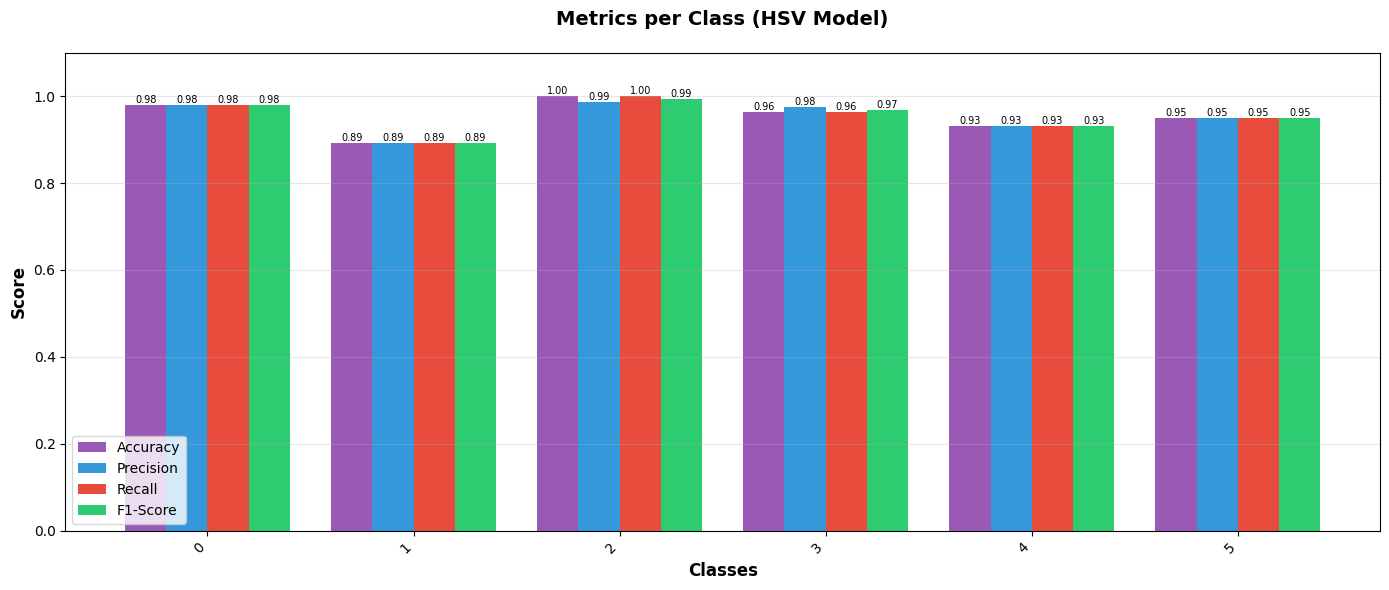


Metrics cho từng lớp (HSV)
Class  Accuracy  Precision   Recall  F1-Score  Support
    0  0.980198   0.980198 0.980198  0.980198      101
    1  0.891304   0.891304 0.891304  0.891304       46
    2  1.000000   0.986486 1.000000  0.993197       73
    3  0.963415   0.975309 0.963415  0.969325       82
    4  0.931818   0.931818 0.931818  0.931818       44
    5  0.950980   0.950980 0.950980  0.950980      102


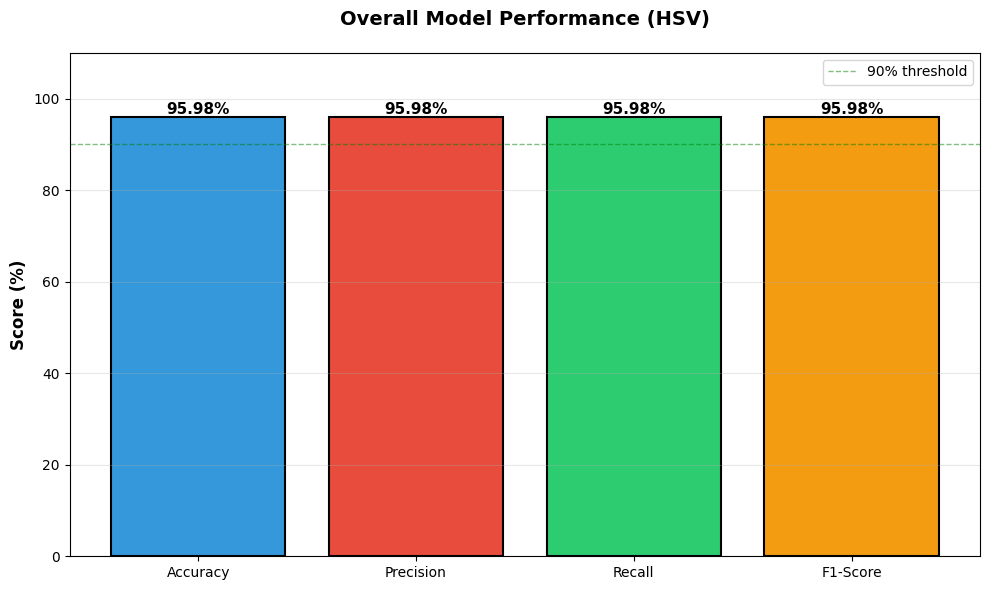

In [16]:
def plot_metrics_per_class(y_true, y_pred, class_names):
    """Vẽ biểu đồ metrics cho từng class"""
    precision_per_class = precision_score(y_true, y_pred, average=None)
    recall_per_class = recall_score(y_true, y_pred, average=None)
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    cm = confusion_matrix(y_true, y_pred)
    accuracy_per_class = cm.diagonal() / cm.sum(axis=1)
    
    x = np.arange(len(class_names))
    width = 0.2
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars1 = ax.bar(x - 1.5*width, accuracy_per_class, width, label='Accuracy', color='#9b59b6')
    bars2 = ax.bar(x - 0.5*width, precision_per_class, width, label='Precision', color='#3498db')
    bars3 = ax.bar(x + 0.5*width, recall_per_class, width, label='Recall', color='#e74c3c')
    bars4 = ax.bar(x + 1.5*width, f1_per_class, width, label='F1-Score', color='#2ecc71')
    
    ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12, fontweight='bold')
    ax.set_title('Metrics per Class (HSV Model)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1.1])
    
    for bars in [bars1, bars2, bars3, bars4]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
    print("Metrics cho từng lớp (HSV)")
    print("=" * 70)
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': accuracy_per_class,
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-Score': f1_per_class,
        'Support': cm.sum(axis=1)
    })
    print(metrics_df.to_string(index=False))
    
    return metrics_df

metrics_df = plot_metrics_per_class(y_true, y_pred, class_names)

def plot_model_comparison():
    """So sánh các metrics tổng quan"""
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics_values = [
        test_results[1] * 100,
        test_precision * 100,
        test_recall * 100,
        test_f1 * 100
    ]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(metrics_names, metrics_values, 
                   color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'],
                   edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Score (%)', fontsize=12, fontweight='bold')
    ax.set_title('Overall Model Performance (HSV)', fontsize=14, fontweight='bold', pad=20)
    ax.set_ylim([0, 110])
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=90, color='green', linestyle='--', linewidth=1, alpha=0.5, label='90% threshold')
    ax.legend()
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}%',
               ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

plot_model_comparison()


In [17]:
print(f"""
=================Thông Tin Model===================

- Kiến trúc: Custom CNN (4 Conv blocks)
- Input shape: {image_size}x{image_size}x{channels} (HSV)
- Color Space: HSV (Hue-Saturation-Value)
- Số lớp phân loại: {num_classes}
- Tổng số parameters: {model.count_params():,}

=================Thông Tin Tập Dữ Liệu===================

- Training samples:   {train_generator.samples:>5} ({steps_per_epoch} steps/epoch)
- Validation samples: {validation_generator.samples:>5} ({validation_steps} steps)
- Test samples:       {test_generator.samples:>5} ({test_steps} steps)
- Classes: {', '.join(class_names)}

=================Thông Tin Hyperparameters===================

- Learning rate (initial): {learning_rate}
- Batch size: {batch_size}
- Epochs trained: {len(history.history['loss'])} / {epochs}
- Optimizer: Adam
- Loss function: Categorical Crossentropy

=================Thông Tin Regularization===================

- Dropout: 0.6
- L2 regularization: 0.002
- Early stopping: patience=15
- Learning rate reduction: factor=0.5, patience=5

=================Kết Quả Training & Validation===================

Training (Final):
  - Accuracy:    {history.history['accuracy'][-1]*100:>6.2f}%
  - Precision:   {history.history['precision'][-1]*100:>6.2f}%
  - Recall:      {history.history['recall'][-1]*100:>6.2f}%
  - Loss:        {history.history['loss'][-1]:>6.4f}

Validation (Final):
  - Accuracy:    {history.history['val_accuracy'][-1]*100:>6.2f}%
  - Precision:   {history.history['val_precision'][-1]*100:>6.2f}%
  - Recall:      {history.history['val_recall'][-1]*100:>6.2f}%
  - Loss:        {history.history['val_loss'][-1]:>6.4f}

Best Validation Metrics:
  - Best Accuracy:  {max(history.history['val_accuracy'])*100:.2f}% (epoch {np.argmax(history.history['val_accuracy'])+1})
  - Best Precision: {max(history.history['val_precision'])*100:.2f}%
  - Best Recall:    {max(history.history['val_recall'])*100:.2f}%

=================Kết Quả Trên Tập Test===================

- Test Accuracy:  {test_results[1]*100:>6.2f}%
- Test Precision: {test_precision*100:>6.2f}%
- Test Recall:    {test_recall*100:>6.2f}%
- Test F1-Score:  {test_f1*100:>6.2f}%
- Test AUC:       {test_results[4]:>6.4f}
- Test Loss:      {test_results[0]:>6.4f}

""")


=================Thông Tin Model===================

- Kiến trúc: Custom CNN (4 Conv blocks)
- Input shape: 150x150x3 (HSV)
- Color Space: HSV (Hue-Saturation-Value)
- Số lớp phân loại: 6
- Tổng số parameters: 3,601,478

=================Thông Tin Tập Dữ Liệu===================

- Training samples:    7245 (227 steps/epoch)
- Validation samples:  1355 (43 steps)
- Test samples:         448 (14 steps)
- Classes: 0, 1, 2, 3, 4, 5

=================Thông Tin Hyperparameters===================

- Learning rate (initial): 0.001
- Batch size: 32
- Epochs trained: 15 / 15
- Optimizer: Adam
- Loss function: Categorical Crossentropy

=================Thông Tin Regularization===================

- Dropout: 0.6
- L2 regularization: 0.002
- Early stopping: patience=15
- Learning rate reduction: factor=0.5, patience=5

=================Kết Quả Training & Validation===================

Training (Final):
  - Accuracy:     96.92%
  - Precision:    97.15%
  - Recall:       96.81%
  - Loss:        0.25